In [4]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import random
import tempfile
import gzip
import pylhe
import math
from auxPlots import  xSecTest, getInfoSMS
from aux import getLHEevents, getDistributions, getInfo, getInfoSummary

pd.option_context('display.max_columns', -1)

pd.options.mode.chained_assignment = None #Disable copy warnings
# plt.style.use('fivethirtyeight') #Set style
# mpl.rcParams.update({'figure.figsize' : (15,10)})  #Set general plotting options
plt.rcParams['figure.max_open_warning'] = 50
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.colormaps['RdYlBu']

In [5]:
def selectColor(model, process):
    if model == 'VLF EFT':
        return sns.color_palette('Paired')[0]
    elif model == '1-loop VLF':
        return sns.color_palette('Paired')[1]
    elif model == 'Scalar EFT':
        return sns.color_palette('Paired')[2]
    elif model == 'SM':
        return sns.color_palette('Paired')[9]
    else:
        return sns.color_palette('Paired')[3]

In [23]:
files = list(glob.glob('/home/vinicius/EFT_ToyModel/processFolders/Distributions/bias/*/*/spinFlip/*.npz'))
data = []
for f in files:
    aux = np.load(f, allow_pickle = True)
    data.append(aux)
    
data = sorted(data, key=lambda d: d['mass_params'][0])

In [9]:
#Reading files
sm_files = list(glob.glob('/home/vinicius/EFT_ToyModel/processFolders/Distributions/bias/sm/*/*.npz'))
bias_2k_2 = []
bias_2k_4 = []
data_sm = []
#Loading the distributions
for f in sm_files:
    aux = np.load(f, allow_pickle = True)
    if '2k_2' in f:
        bias_2k_2.append(aux)
    elif '2k_4' in f:
        bias_2k_4.append(aux)
    else:
        data_sm.append(aux)
        
    
        
data_sm.append(bias_2k_2)
data_sm.append(bias_2k_4)

print(len(data_sm[-2]))

    

2


In [28]:
xSecTest(data)

VLF EFT $g g \to t \bar{t}$  mPsiT: 400.0, mSDM: 300.0 Result: Passed
VLF EFT $q q \to t \bar{t}$  mPsiT: 400.0, mSDM: 300.0 Result: Passed
1-loop VLF $g g \to t \bar{t}$  mPsiT: 400.0, mSDM: 300.0 Result: Passed
1-loop VLF $q q \to t \bar{t}$  mPsiT: 400.0, mSDM: 300.0 Result: Passed
Scalar EFT $g g \to t \bar{t}$  mPsiT: 400.0, mSDM: 300.0 Result: Passed
Scalar EFT $q q \to t \bar{t}$  mPsiT: 400.0, mSDM: 300.0 Result: Passed
1-loop Scalar $g g \to t \bar{t}$  mPsiT: 400.0, mSDM: 300.0 Result: Passed
1-loop Scalar $q q \to t \bar{t}$  mPsiT: 400.0, mSDM: 300.0 Result: Passed
VLF EFT $g g \to t \bar{t}$  mPsiT: 500.0, mSDM: 400.0 Result: Passed
VLF EFT $q q \to t \bar{t}$  mPsiT: 500.0, mSDM: 400.0 Result: Passed
1-loop VLF $g g \to t \bar{t}$  mPsiT: 500.0, mSDM: 400.0 Result: Passed
1-loop VLF $q q \to t \bar{t}$  mPsiT: 500.0, mSDM: 400.0 Result: Passed
Scalar EFT $g g \to t \bar{t}$  mPsiT: 500.0, mSDM: 400.0 Result: Passed
Scalar EFT $q q \to t \bar{t}$  mPsiT: 500.0, mSDM: 400.0

In [36]:
for d in data:
    print(d['model'], d['mass_params'])

VLF EFT [400. 300.]
VLF EFT [400. 300.]
1-loop VLF [400. 300.]
1-loop VLF [400. 300.]
Scalar EFT [400. 300.]
Scalar EFT [400. 300.]
1-loop Scalar [400. 300.]
1-loop Scalar [400. 300.]
VLF EFT [500. 400.]
VLF EFT [500. 400.]
1-loop VLF [500. 400.]
1-loop VLF [500. 400.]
Scalar EFT [500. 400.]
Scalar EFT [500. 400.]
1-loop Scalar [500. 400.]
1-loop Scalar [500. 400.]
VLF EFT [600. 500.]
VLF EFT [600. 500.]
1-loop VLF [600. 500.]
1-loop VLF [600. 500.]
Scalar EFT [600. 500.]
Scalar EFT [600. 500.]
1-loop Scalar [600. 500.]
1-loop Scalar [600. 500.]
VLF EFT [700. 600.]
VLF EFT [700. 600.]
1-loop VLF [700. 600.]
1-loop VLF [700. 600.]
Scalar EFT [700. 600.]
Scalar EFT [700. 600.]
1-loop Scalar [700. 600.]
1-loop Scalar [700. 600.]
VLF EFT [1000.  900.]
VLF EFT [1000.  900.]
1-loop VLF [1000.  900.]
1-loop VLF [1000.  900.]
Scalar EFT [1000.  900.]
Scalar EFT [1000.  900.]
1-loop Scalar [1000.  900.]
1-loop Scalar [1000.  900.]


In [37]:
print(np.arange(500.,4000.,50.))

[ 500.  550.  600.  650.  700.  750.  800.  850.  900.  950. 1000. 1050.
 1100. 1150. 1200. 1250. 1300. 1350. 1400. 1450. 1500. 1550. 1600. 1650.
 1700. 1750. 1800. 1850. 1900. 1950. 2000. 2050. 2100. 2150. 2200. 2250.
 2300. 2350. 2400. 2450. 2500. 2550. 2600. 2650. 2700. 2750. 2800. 2850.
 2900. 2950. 3000. 3050. 3100. 3150. 3200. 3250. 3300. 3350. 3400. 3450.
 3500. 3550. 3600. 3650. 3700. 3750. 3800. 3850. 3900. 3950.]


# Invariant mass $qq\to t\bar{t}$

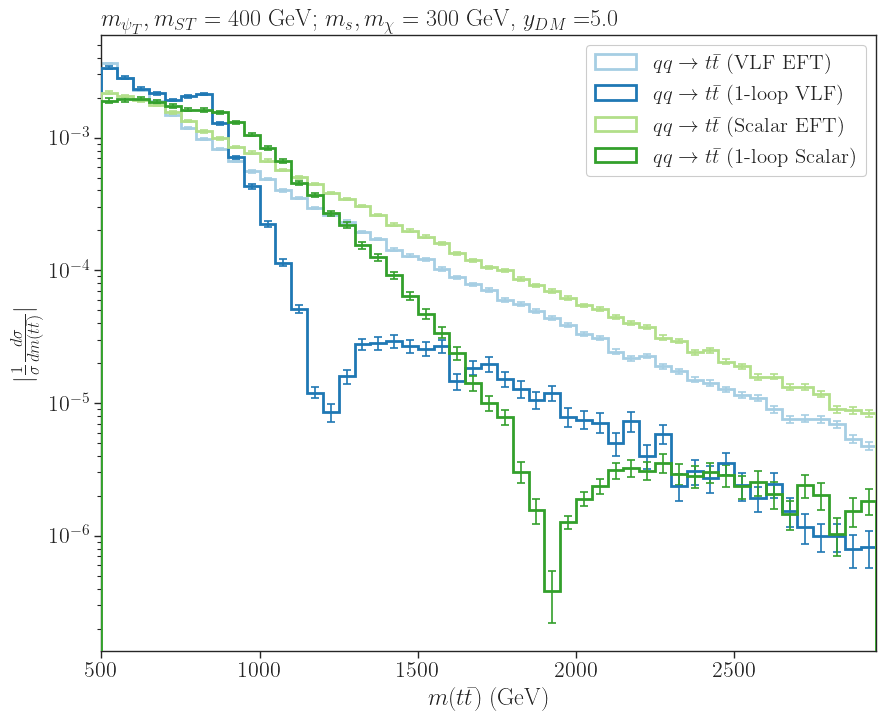

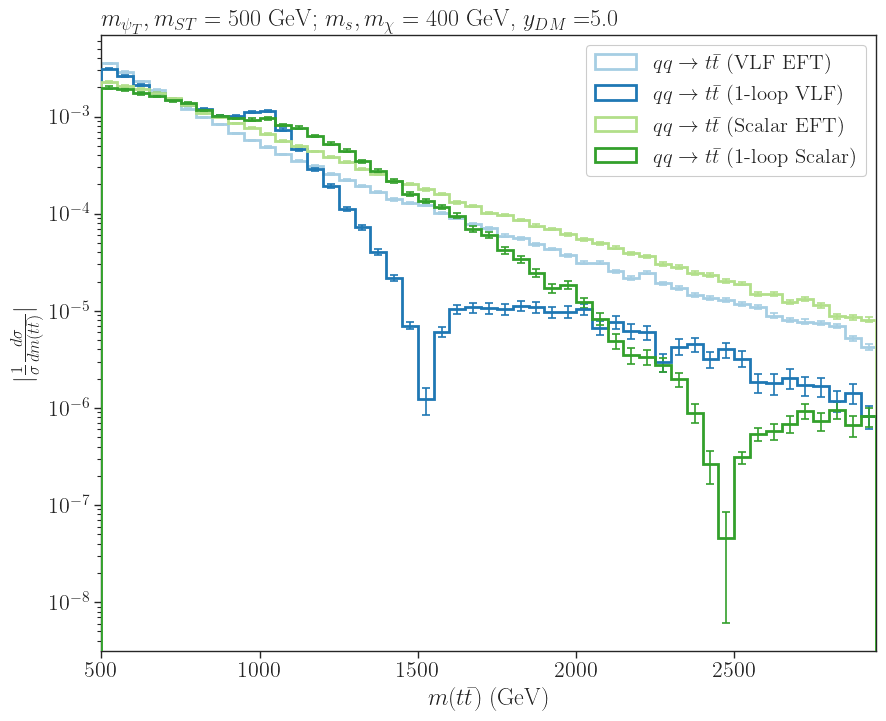

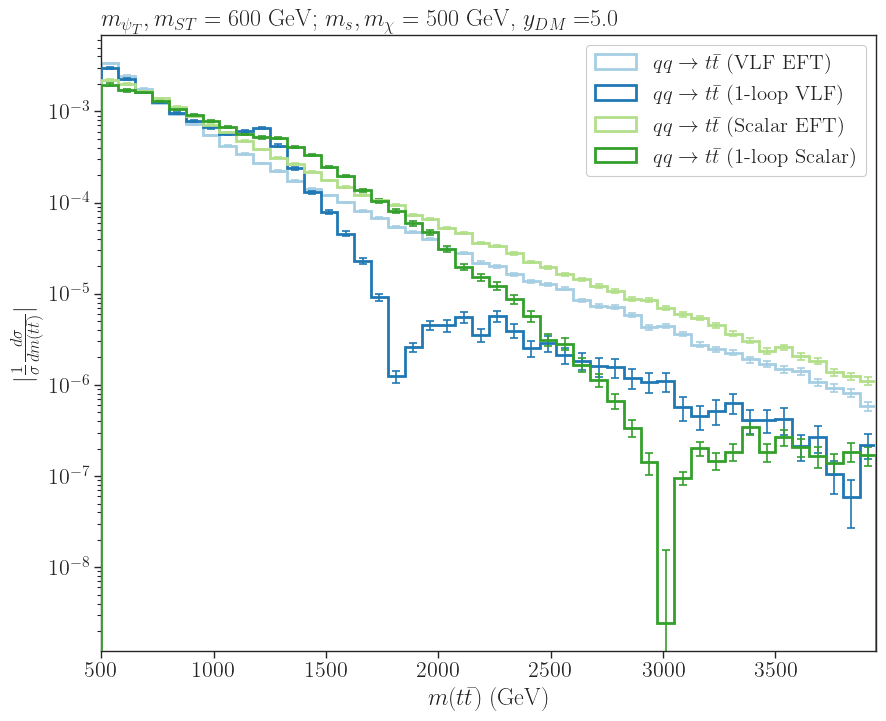

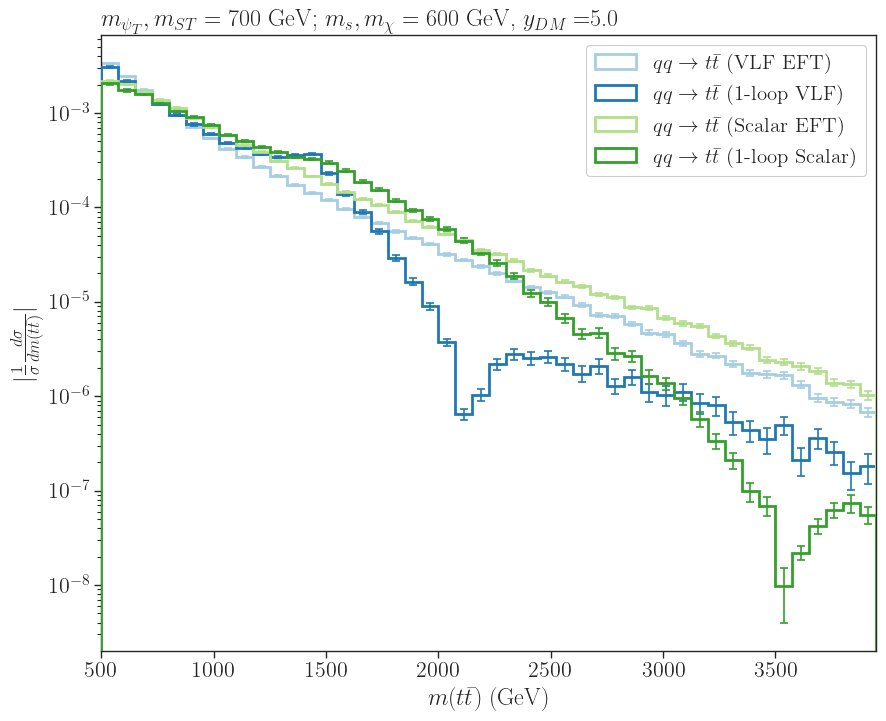

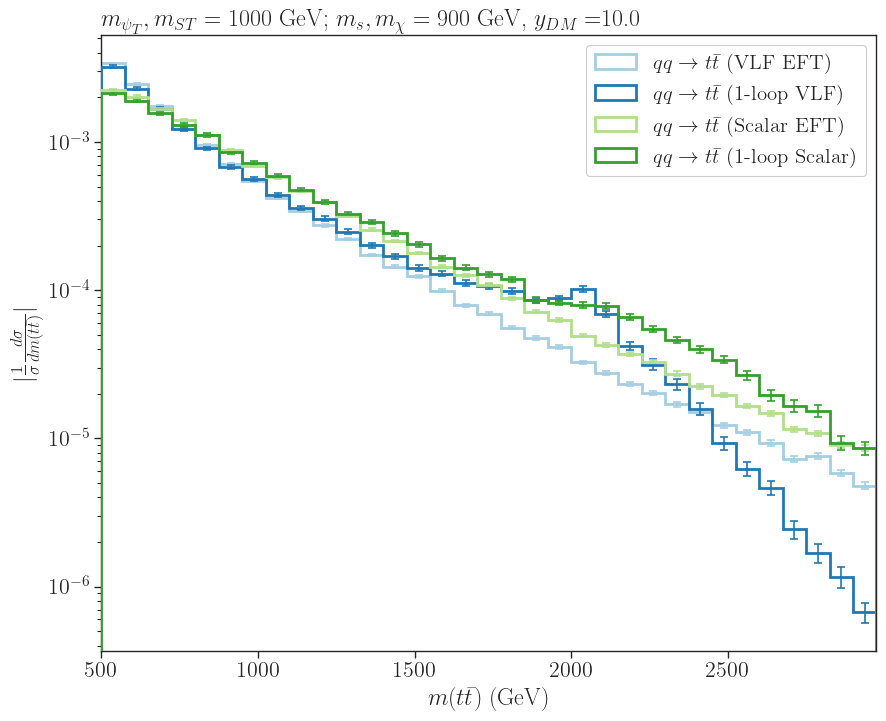

In [40]:
# Loop over the masses configurations.
for i in range(0, len(data), 8):
    # Selecting the models and process for the same mass configuration
    selected = data[i : i+8]

    
    fig, ax = plt.subplots(figsize=(10, 8))

    # Variables used to store hist info
    mPsiT, mSDM = selected[0]['mass_params']
    yDM = selected[0]['ydm']
    
    # Defining the binning
    bins = np.arange(500., 3000., 50.)
    if mPsiT < 600:
        bins = np.arange(500., 3000., 50.)
    elif mPsiT < 1000:
        bins = np.arange(500., 4000., 75.)
    else:
        bins = np.arange(500., 3000., 75.)



    
    # Loop over the processes and models
    for j, d in enumerate(selected):
        if r'$g g \to t \bar{t}$' in d['process']:
            continue
        else:
            process = d['process']
            model = d['model']
            weights = d['weights']
            label = f"{process} ({model})"
            color = selectColor(model, process)
            
            h, _ = np.histogram(d['mTT'], bins=bins, weights=d['weights'])
            hErr, _ = np.histogram(d['mTT'], bins=bins, weights=(d['weights'])**2)
            hErr = np.sqrt(hErr)
            
            # --- CHANGE 2: Plot on the single axis 'ax' ---
            # Plotting the BSM hists
            aux = ax.hist(bins[:-1], weights=abs(h), label=label, bins=bins,
                          color=color, alpha=1.0, histtype='step', density=True,
                          linewidth=2, fill=False, zorder=j)
            
            # Plotting the errors
            x = (bins[:-1] + bins[1:]) / 2.0
            y = aux[0]
            # Propagating the error
            yErr = abs(y) * np.sqrt((hErr/h)**2 + np.sum(hErr**2) / (np.sum(h)**2))
            ax.errorbar(x, y, yerr=yErr,
                        color=color, fmt='none', capsize=3, capthick=1.2, barsabove=True)


    # Main plot configs
    ax.legend(framealpha=1.0, loc='upper right', fontsize=15)
    ax.set_title(r'$m_{\psi_T}, m_{ST} = %1.0f$ GeV; $m_{s}, m_{\chi} = %1.0f$ GeV, $y_{DM} = $%1.1f' % (mPsiT, mSDM, yDM), loc='left')
    ax.set_yscale('log')
    ax.set_ylabel(r'$|\frac{1}{\sigma}\frac{d \sigma}{d m(t\bar{t})}|$')
    ax.set_xlabel(r'$m(t\bar{t})$ (GeV)') 
    ax.set_xlim(bins.min(), bins.max())
    #ax.grid(True, linestyle='--')

plt.show()

In [39]:
# 1225 1925
print('400 300 psiT/ST',1225/1925)
# 2475 1525
print('500 400 psiT/ST', 1525/2475)
# 3025 1825
print('600 500 psiT/ST', 1825/3025)
# 3625 2125
print('700 600 psiT/ST', 2125/3625)
#5225 3025
print('1000 900 psiT/ST', 3025/5225)

400 300 psiT/ST 0.6363636363636364
500 400 psiT/ST 0.6161616161616161
600 500 psiT/ST 0.6033057851239669
700 600 psiT/ST 0.5862068965517241
1000 900 psiT/ST 0.5789473684210527


# Top pair invariant mass $gg \to t \bar{t}$

In [40]:
# 1225 875
print('400 300 ST/psiT', 875/1225)
# 1625 1225
print('500 400 ST/psiT', 1225/1625)
# 1975 1425
print('600 500 ST/psiT', 1425/1975)
# 3625 2125
print('700 600 ST/psiT', 2125/3625)
#5225 3025
print('1000 900 ST/psiT', 3025/5225)

400 300 ST/psiT 0.7142857142857143
500 400 ST/psiT 0.7538461538461538
600 500 ST/psiT 0.7215189873417721
700 600 ST/psiT 0.5862068965517241
1000 900 ST/psiT 0.5789473684210527


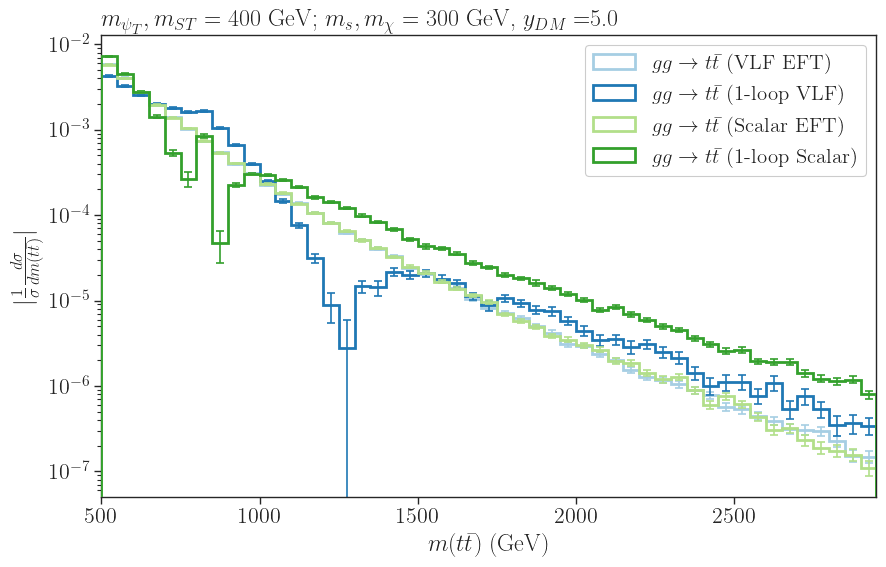

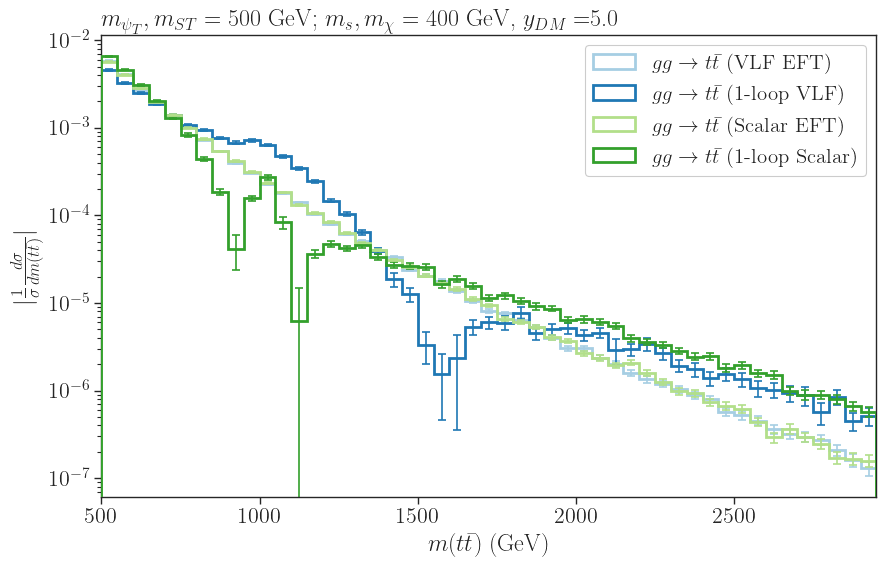

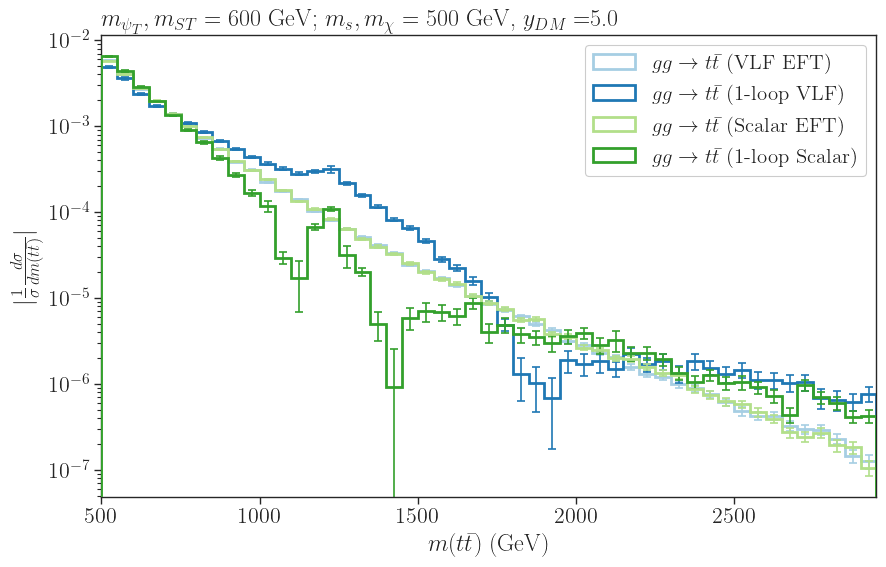

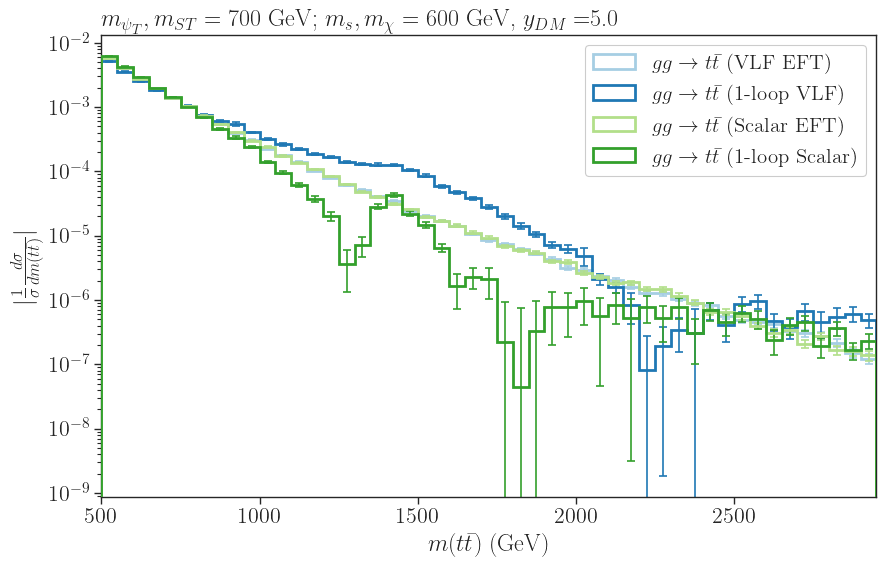

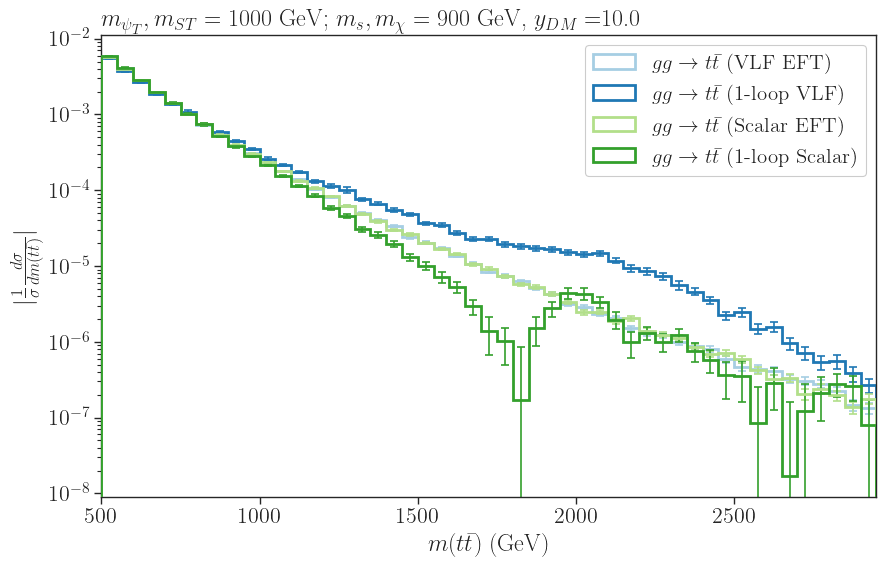

In [41]:
# Loop over the masses configurations.
for i in range(0, len(data), 8):
    # Selecting the models and process for the same mass configuration
    selected = data[i : i+8]

   
    fig, ax = plt.subplots(figsize=(10, 6)) # Changed from subplots(2,...)

    # Variables used to store hist info
    mPsiT, mSDM = selected[0]['mass_params']
    yDM = selected[0]['ydm']
    
    # Defining the binning
    bins = np.arange(500., 3000., 50.)
    
    # variables to store info
    pmodels = []
    
    # Loop over the processes and models
    for j, d in enumerate(selected):
        if r'$q q \to t \bar{t}$' in d['process']:
            # This part of your logic skips the qq process, so we keep it
            continue
        else:
            process = d['process']
            model = d['model']
            weights = d['weights']
            label = f"{process} ({model})"
            color = selectColor(model, process)
            
            h, _ = np.histogram(d['mTT'], bins=bins, weights=d['weights'])
            hErr, _ = np.histogram(d['mTT'], bins=bins, weights=(d['weights'])**2)
            hErr = np.sqrt(hErr)
            
            
            # Plotting the BSM hists
            aux = ax.hist(bins[:-1], weights=abs(h), label=label, bins=bins,
                          color=color, alpha=1.0, histtype='step', density=True,
                          linewidth=2, fill=False, zorder=j)
            
            # Plotting the errors
            x = (bins[:-1] + bins[1:]) / 2.0
            y = aux[0]
            # Propagating the error
            yErr = abs(y) * np.sqrt((hErr/h)**2 + np.sum(hErr**2) / (np.sum(h)**2))
            ax.errorbar(x, y, yerr=yErr,
                        color=color, fmt='none', capsize=3, capthick=1.2, barsabove=True)



    # Main plot configs
    ax.legend(framealpha=1.0, loc='upper right', fontsize=15)
    ax.set_title(r'$m_{\psi_T}, m_{ST} = %1.0f$ GeV; $m_{s}, m_{\chi} = %1.0f$ GeV, $y_{DM} = $%1.1f' % (mPsiT, mSDM, yDM), loc='left')
    ax.set_yscale('log')
    ax.set_ylabel(r'$|\frac{1}{\sigma}\frac{d \sigma}{d m(t\bar{t})}|$')
    ax.set_xlabel(r'$m(t\bar{t})$ (GeV)') # Moved x-label to the main plot
    ax.set_xlim(bins.min(), bins.max())
    #ax.grid(True, linestyle='--')
    
plt.show()


# $p_T$ $qq\to t\bar{t}$

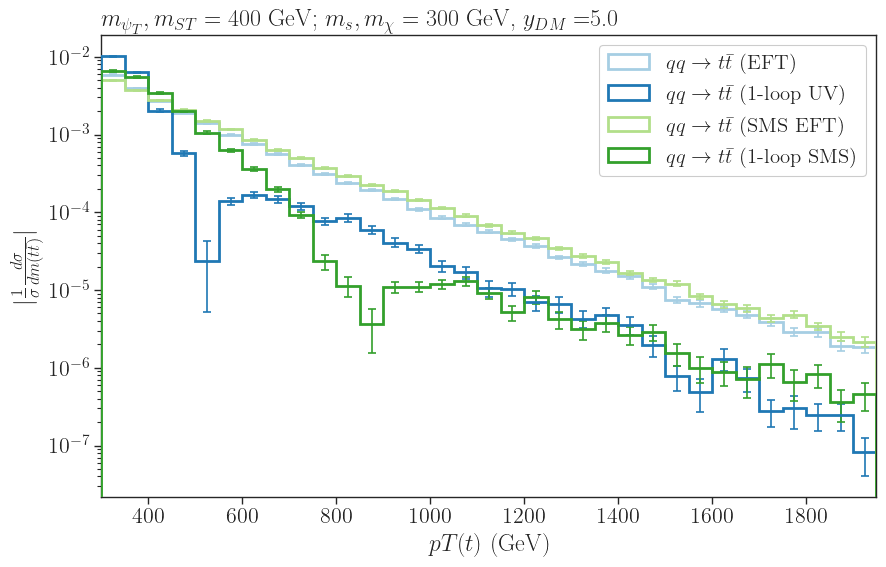

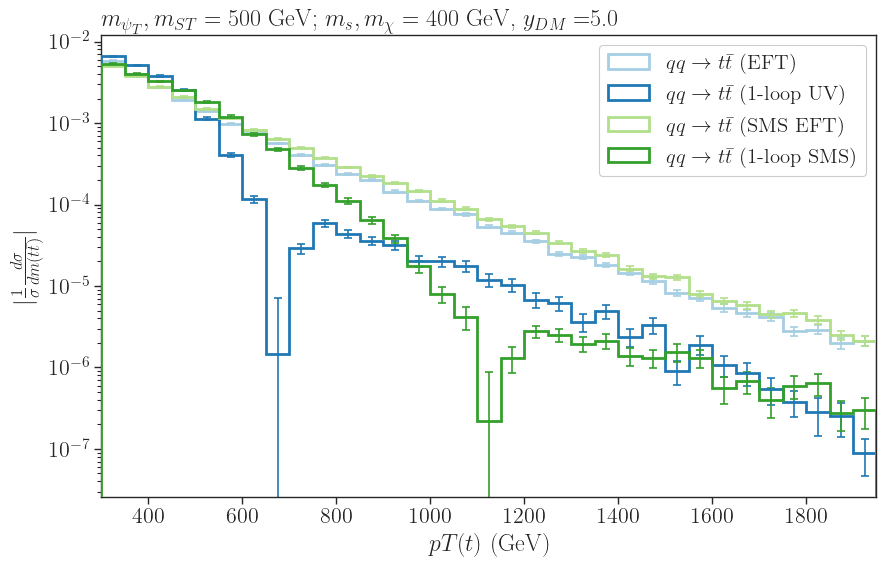

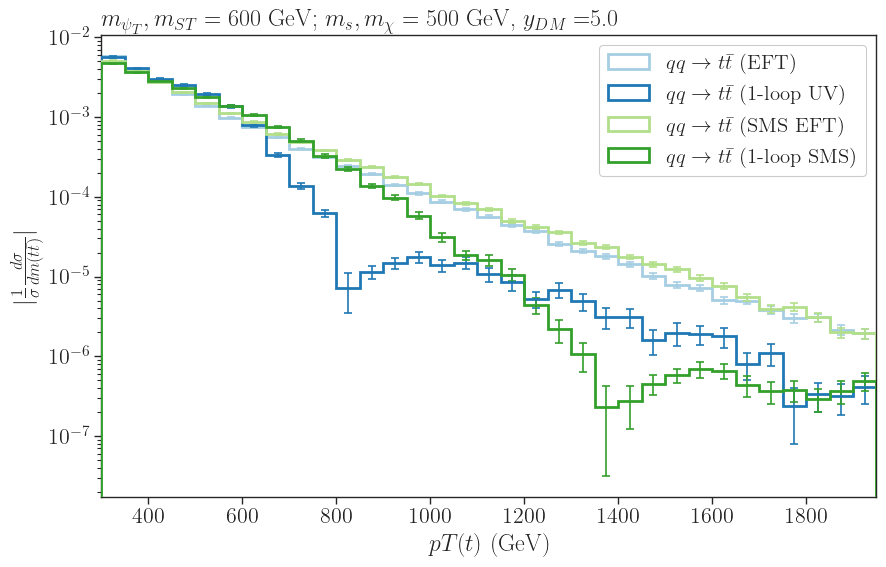

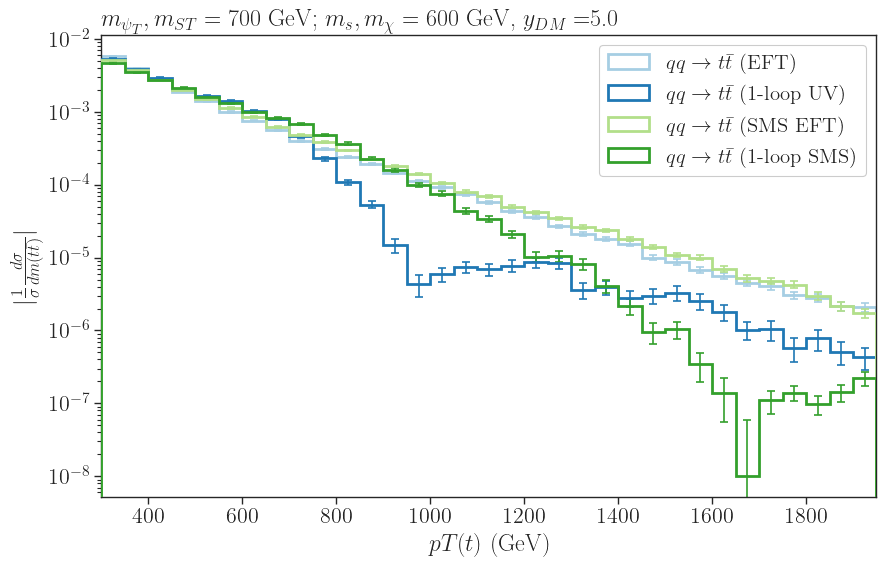

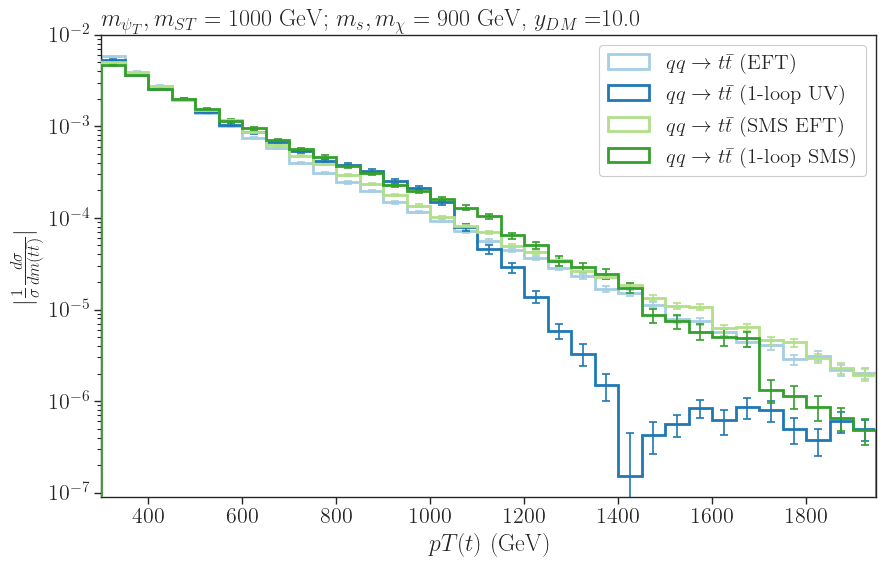

In [53]:
# Loop over the masses configurations.
for i in range(0, len(data), 8):
    # Selecting the models and process for the same mass configuration
    selected = data[i : i+8]

   
    fig, ax = plt.subplots(figsize=(10, 6)) # Changed from subplots(2,...)

    # Variables used to store hist info
    mPsiT, mSDM = selected[0]['mass_params']
    yDM = selected[0]['ydm']
    
    # Defining the binning
    bins = np.arange(300., 2000., 50.)
    
    # variables to store info
    pmodels = []
    
    # Loop over the processes and models
    for j, d in enumerate(selected):
        if r'$g g \to t \bar{t}$' in d['process']:
            # This part of your logic skips the qq process, so we keep it
            continue
        else:
            process = d['process']
            model = d['model']
            weights = d['weights']
            label = f"{process} ({model})"
            color = selectColor(model, process)
            
            h, _ = np.histogram(d['pT'], bins=bins, weights=d['weights'])
            hErr, _ = np.histogram(d['pT'], bins=bins, weights=(d['weights'])**2)
            hErr = np.sqrt(hErr)
            
            
            # Plotting the BSM hists
            aux = ax.hist(bins[:-1], weights=abs(h), label=label, bins=bins,
                          color=color, alpha=1.0, histtype='step', density=True,
                          linewidth=2, fill=False, zorder=j)
            
            # Plotting the errors
            x = (bins[:-1] + bins[1:]) / 2.0
            y = aux[0]
            # Propagating the error
            yErr = abs(y) * np.sqrt((hErr/h)**2 + np.sum(hErr**2) / (np.sum(h)**2))
            ax.errorbar(x, y, yerr=yErr,
                        color=color, fmt='none', capsize=3, capthick=1.2, barsabove=True)



    # Main plot configs
    ax.legend(framealpha=1.0, loc='upper right', fontsize=15)
    ax.set_title(r'$m_{\psi_T}, m_{ST} = %1.0f$ GeV; $m_{s}, m_{\chi} = %1.0f$ GeV, $y_{DM} = $%1.1f' % (mPsiT, mSDM, yDM), loc='left')
    ax.set_yscale('log')
    ax.set_ylabel(r'$|\frac{1}{\sigma}\frac{d \sigma}{d m(t\bar{t})}|$')
    ax.set_xlabel(r'$pT(t)$ (GeV)') 
    ax.set_xlim(bins.min(), bins.max())
    #ax.grid(True, linestyle='--')
    
plt.show()

# $p_T$ $gg\to t\bar{t}$

/tmp/ipykernel_6421/1236627889.py:45: RuntimeWarning: invalid value encountered in divide
  yErr = abs(y) * np.sqrt((hErr/h)**2 + np.sum(hErr**2) / (np.sum(h)**2))


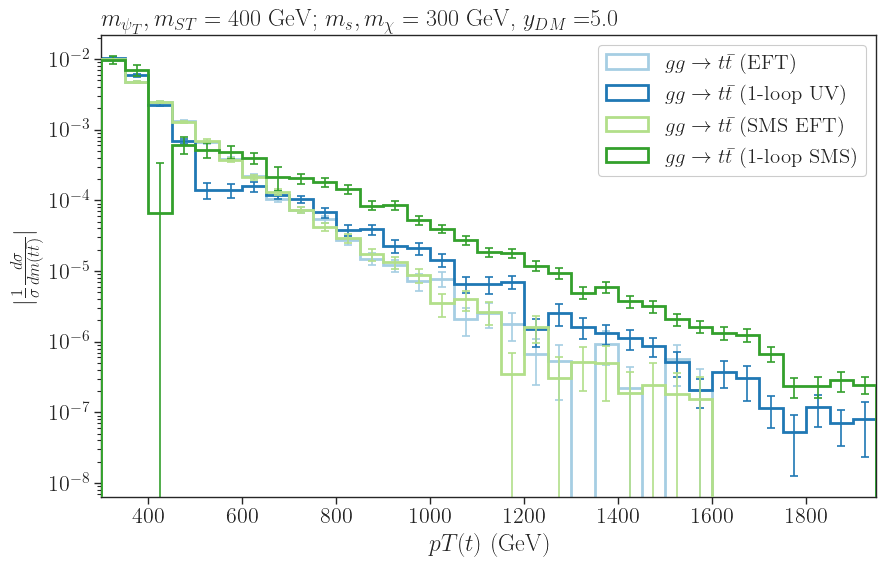

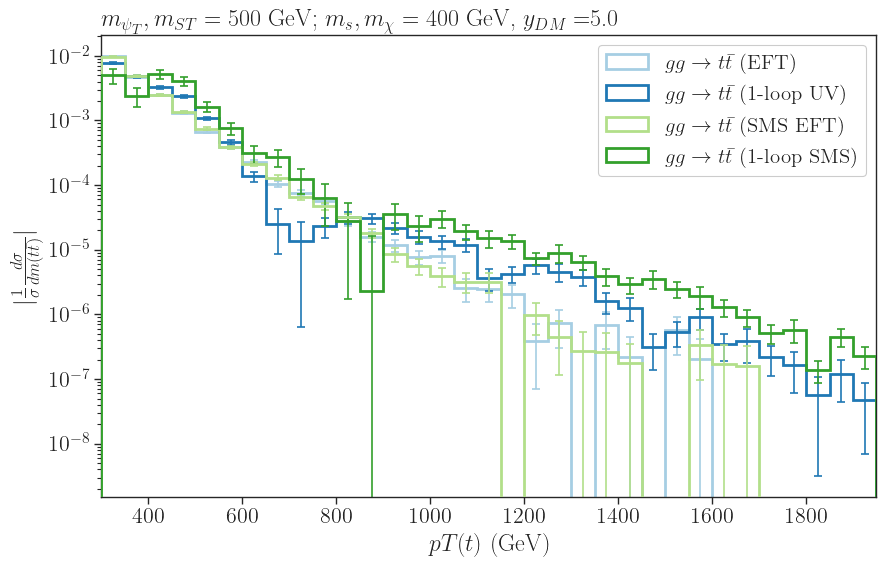

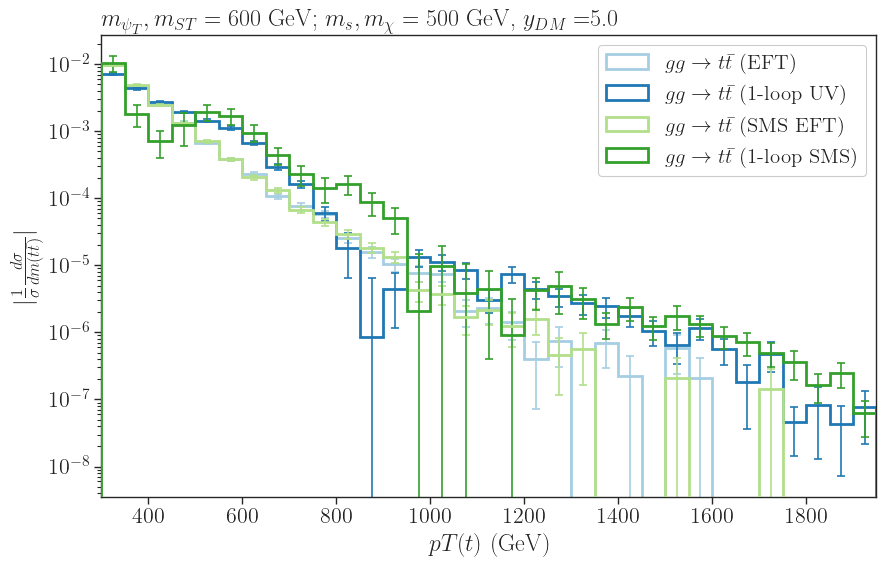

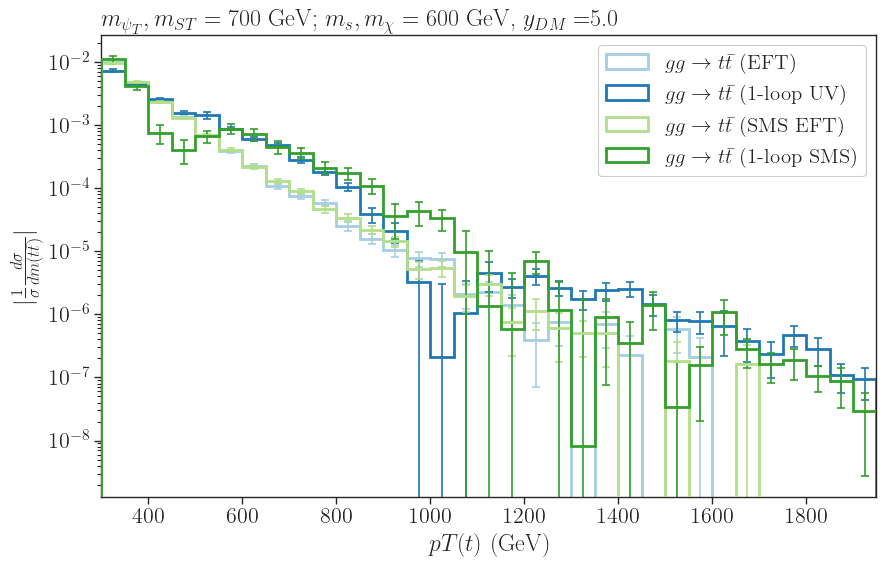

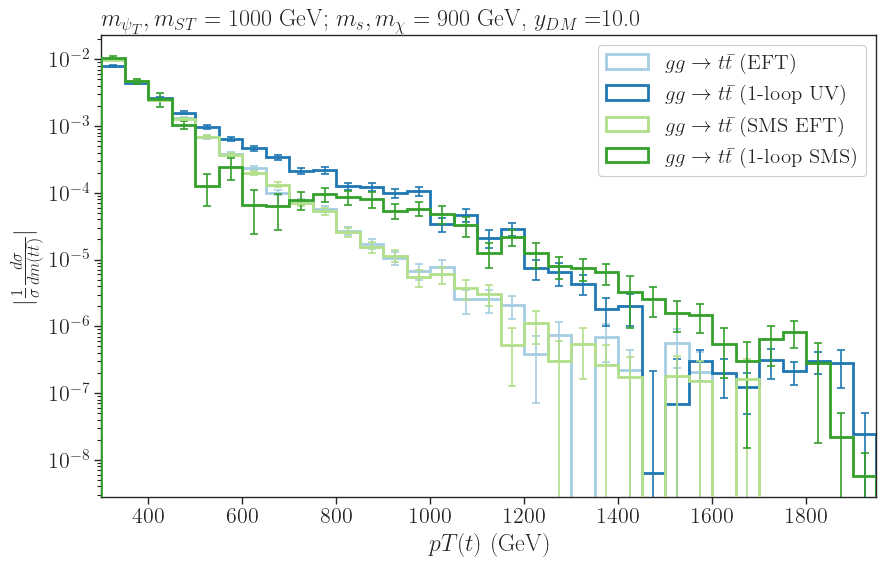

In [55]:
# Loop over the masses configurations.
for i in range(0, len(data), 8):
    # Selecting the models and process for the same mass configuration
    selected = data[i : i+8]

   
    fig, ax = plt.subplots(figsize=(10, 6)) # Changed from subplots(2,...)

    # Variables used to store hist info
    mPsiT, mSDM = selected[0]['mass_params']
    yDM = selected[0]['ydm']
    
    # Defining the binning
    bins = np.arange(300., 2000., 50.)
    
    # variables to store info
    pmodels = []
    
    # Loop over the processes and models
    for j, d in enumerate(selected):
        if r'$q q \to t \bar{t}$' in d['process']:
            # This part of your logic skips the qq process, so we keep it
            continue
        else:
            process = d['process']
            model = d['model']
            weights = d['weights']
            label = f"{process} ({model})"
            color = selectColor(model, process)
            
            h, _ = np.histogram(d['pT'], bins=bins, weights=d['weights'])
            hErr, _ = np.histogram(d['pT'], bins=bins, weights=(d['weights'])**2)
            hErr = np.sqrt(hErr)
            
            
            # Plotting the BSM hists
            aux = ax.hist(bins[:-1], weights=abs(h), label=label, bins=bins,
                          color=color, alpha=1.0, histtype='step', density=True,
                          linewidth=2, fill=False, zorder=j)
            
            # Plotting the errors
            x = (bins[:-1] + bins[1:]) / 2.0
            y = aux[0]
            # Propagating the error
            yErr = abs(y) * np.sqrt((hErr/h)**2 + np.sum(hErr**2) / (np.sum(h)**2))
            ax.errorbar(x, y, yerr=yErr,
                        color=color, fmt='none', capsize=3, capthick=1.2, barsabove=True)



    # Main plot configs
    ax.legend(framealpha=1.0, loc='upper right', fontsize=15)
    ax.set_title(r'$m_{\psi_T}, m_{ST} = %1.0f$ GeV; $m_{s}, m_{\chi} = %1.0f$ GeV, $y_{DM} = $%1.1f' % (mPsiT, mSDM, yDM), loc='left')
    ax.set_yscale('log')
    ax.set_ylabel(r'$|\frac{1}{\sigma}\frac{d \sigma}{d m(t\bar{t})}|$')
    ax.set_xlabel(r'$pT(t)$ (GeV)') 
    ax.set_xlim(bins.min(), bins.max())
    #ax.grid(True, linestyle='--')
    
plt.show()

# Combining the process to obtain $pp \to t\bar{t}$

In [24]:
files = list(glob.glob('/home/vinicius/EFT_ToyModel/processFolders/Distributions/bias/*/*/run_exp/*.npz'))
data_exp = []
for f in files:
    aux = np.load(f, allow_pickle = True)
    data_exp.append(aux)
    
data_exp = sorted(data_exp, key=lambda d: d['mass_params'][0])

In [25]:
#Reading files with bias
sm_files = list(glob.glob('/home/vinicius/EFT_ToyModel/processFolders/Distributions/bias/sm/pp2ttbar_gs4/*.npz'))
data_sm_exp = []
#Loading the distributions
for f in  sm_files:
    aux = np.load(f, allow_pickle = True)
    data_sm_exp.append(aux)
        


data_sm_exp = sorted(data_sm_exp, key=lambda d: d['mass_params'][0])

VLF EFT VLF EFT
1-loop VLF 1-loop VLF
Scalar EFT Scalar EFT
1-loop Scalar 1-loop Scalar
VLF EFT VLF EFT
1-loop VLF 1-loop VLF


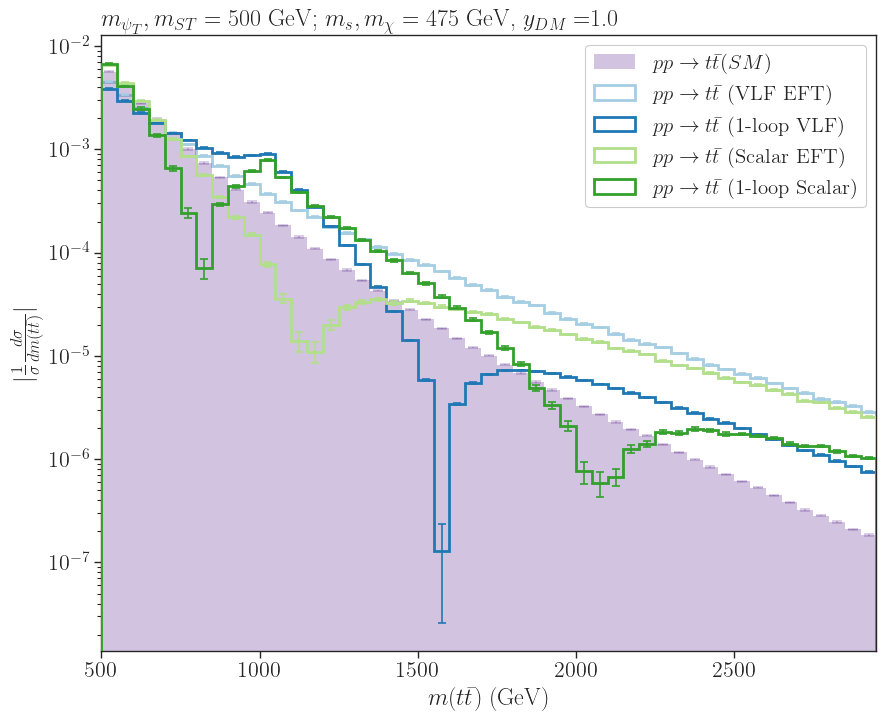

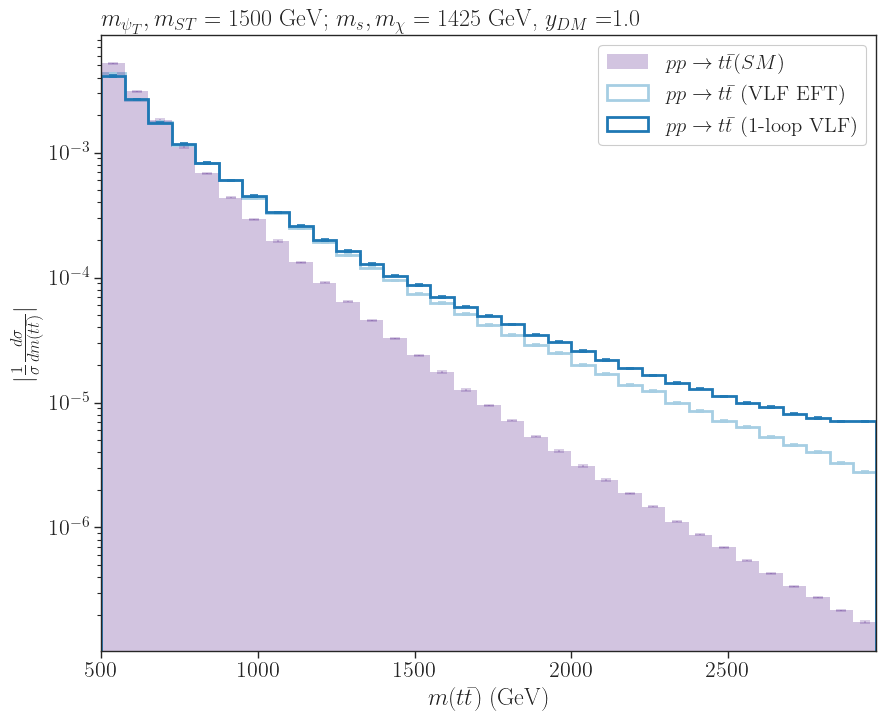

In [26]:
# Loop over the masses configurations.
for i in range(0, len(data_exp), 8):
    # Selecting the models and process for the same mass configuration
    selected = data_exp[i : i+8]

    
    fig, ax = plt.subplots(figsize=(10, 8))

    # Variables used to store hist info
    mPsiT, mSDM = selected[0]['mass_params']
    yDM = selected[0]['ydm']
    
    # Defining the binning
    bins = np.arange(500., 3000., 50.)
    if mPsiT < 600:
        bins = np.arange(500., 3000., 50.)
    elif mPsiT < 1000:
        bins = np.arange(500., 4000., 75.)
    else:
        bins = np.arange(500., 3000., 75.)


    #SM plot arrays
    labels_sm = []
    pmodels = []
    hists_sm = []
    histsErr_sm = []

    
    selected_sm = data_sm_exp

    #Loop over qq and gg to generate pp
    for d in selected_sm:
        process = d['process']
        model = d['model']
        weights = d['weights']
        pmodels.append(r'%s (%s)' %(process,model))
        label = pmodels[-1]
        labels_sm.append(label)
        h,_ = np.histogram(d['mTT'],bins=bins,weights=d['weights'])
        hists_sm.append(h)
        #Compute MC error
        hErr,_ = np.histogram(d['mTT'],bins=bins,weights=(np.array(d['weights']))**2)
        hErr = np.sqrt(hErr)    
        histsErr_sm.append(hErr)
    #Plotting the SM hist
        aux = ax.hist(bins[:-1],weights=np.abs(h),label=r'$p p \to t\bar{t} (SM)$',bins=bins,
                          color=sns.color_palette('Paired')[9],alpha=0.3,histtype='step',density=True,
                         linewidth=0,fill=True,stacked=True,linestyle='solid')
         #Plotting the SM error
        x = (bins[:-1]+bins[1:])/2.0
        y = aux[0]
        #We have to propagate the error because we are using density = True
        yErr = abs(y)*np.sqrt((np.array(histsErr_sm[0])/np.array(hists_sm[0]))**2 + sum(np.power(histsErr_sm[0],2))/(sum(hists_sm[0])**2))  
        #Plot
        ax.errorbar(x,y, yerr = yErr,
                        color=sns.color_palette('Paired')[9], fmt = 'none', ms = 5, capsize = 3.5, capthick = 1.2, 
                          ecolor =sns.color_palette('Paired')[9], barsabove = True, alpha = 0.3)
    
    # Loop over the processes and models
    d = selected
    for j in range(0,len(d),2):
        print(d[j]['model'], d[j+1]['model'])
        process = r'$p p \to t \bar{t}$'
        model = d[j]['model']
        weights = d[j]['weights']
        label = f"{process} ({model})"
        color = selectColor(model, process)
        
        h1, _ = np.histogram(d[j]['mTT'], bins=bins, weights=d[j]['weights'])
        hErr1, _ = np.histogram(d[j]['mTT'], bins=bins, weights=(d[j]['weights'])**2)
        hErr1 = np.sqrt(hErr1)

        h2, _ = np.histogram(d[j+1]['mTT'], bins=bins, weights=d[j+1]['weights'])
        hErr2, _ = np.histogram(d[j+1]['mTT'], bins=bins, weights=(d[j+1]['weights'])**2)
        hErr2 = np.sqrt(hErr2)
        
        h = sum([h1,h2])
        hErr = np.sqrt(hErr1**2 + hErr2**2)
        # --- CHANGE 2: Plot on the single axis 'ax' ---
        # Plotting the BSM hists
        aux = ax.hist(bins[:-1], weights=abs(h), label=label, bins=bins,
                      color=color, alpha=1.0, histtype='step', density = True,
                      linewidth=2, fill=False, zorder=j)
        
        # Plotting the errors
        x = (bins[:-1] + bins[1:]) / 2.0
        y = aux[0]
        # Propagating the error
        yErr = abs(y) * np.sqrt((hErr/h)**2 + np.sum(hErr**2) / (np.sum(h)**2))
        ax.errorbar(x, y, yerr=yErr,
                    color=color, fmt='none', capsize=3, capthick=1.2, barsabove=True)


    # Main plot configs
    ax.legend(framealpha=1.0, loc='upper right', fontsize=15)
    ax.set_title(r'$m_{\psi_T}, m_{ST} = %1.0f$ GeV; $m_{s}, m_{\chi} = %1.0f$ GeV, $y_{DM} = $%1.1f' % (mPsiT, mSDM, yDM), loc='left')
    ax.set_yscale('log')
    ax.set_ylabel(r'$|\frac{1}{\sigma}\frac{d \sigma}{d m(t\bar{t})}|$')
    ax.set_xlabel(r'$m(t\bar{t})$ (GeV)') 
    ax.set_xlim(bins.min(), bins.max())
    #ax.grid(True, linestyle='--')

plt.show()

[NpzFile '/home/vinicius/EFT_ToyModel/processFolders/Distributions/bias/TopEFT/gg2ttbar_gs4_ydm2/run_exp/mPsiT_500_mSDM_475.npz' with keys: mTT, pT1, pT2, deltaPhi, weights..., NpzFile '/home/vinicius/EFT_ToyModel/processFolders/Distributions/bias/TopEFT/qq2ttbar_gs4_ydm2/run_exp/mPsiT_500_mSDM_475.npz' with keys: mTT, pT1, pT2, deltaPhi, weights..., NpzFile '/home/vinicius/EFT_ToyModel/processFolders/Distributions/bias/UV_BSM/gg2ttbar_gs4_ydm2/run_exp/mPsiT_500_mSDM_475.npz' with keys: mTT, pT1, pT2, deltaPhi, weights..., NpzFile '/home/vinicius/EFT_ToyModel/processFolders/Distributions/bias/UV_BSM/qq2ttbar_gs4_ydm2/run_exp/mPsiT_500_mSDM_475.npz' with keys: mTT, pT1, pT2, deltaPhi, weights..., NpzFile '/home/vinicius/EFT_ToyModel/processFolders/Distributions/bias/SMS_EFT/gg2ttbar_gs4_ydm2/run_exp/mPsiT_500_mSDM_475.npz' with keys: mTT, pT1, pT2, deltaPhi, weights..., NpzFile '/home/vinicius/EFT_ToyModel/processFolders/Distributions/bias/SMS_EFT/qq2ttbar_gs4_ydm2/run_exp/mPsiT_500_mSD

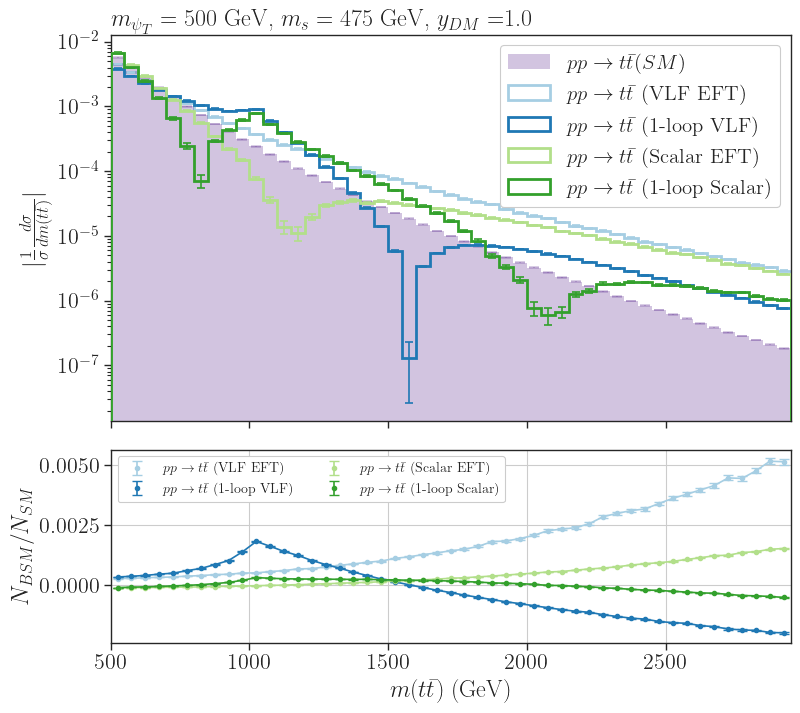

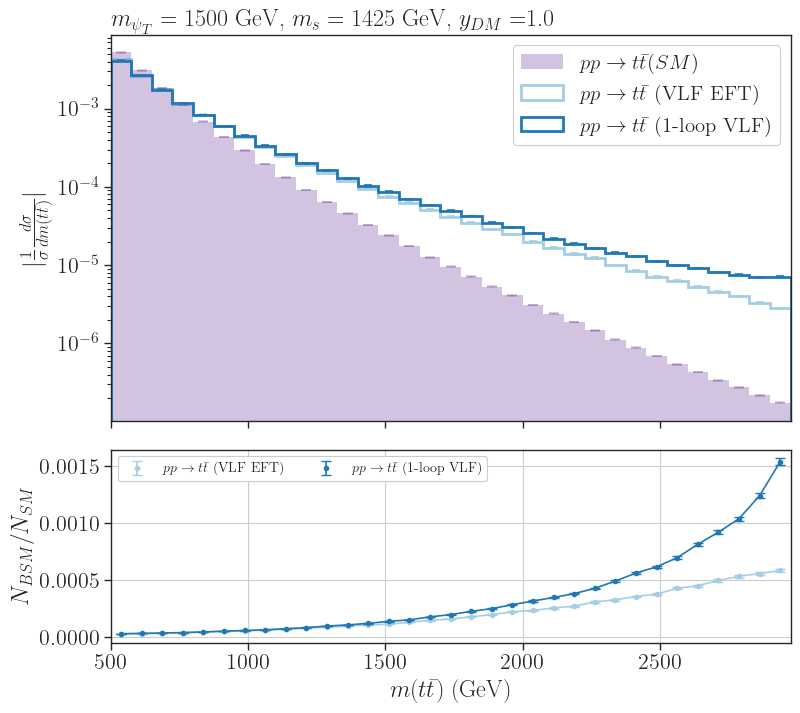

In [72]:



# Generating the BSM histograms and plotting them

#Selecting the type of subplot
ratio_plot = True


#Loop over the masses configurations. Each mass configuration has 2 models with 2 processes each
for i in range(0, len(data_exp), 8):
    #Selecting the models and process for the same mass configuration
    selected = data_exp[i : i+8]

    #Defining the space for the two plots 
    _, axarr = plt.subplots(2,sharex=True, gridspec_kw = {'height_ratios':[2, 1]},figsize=(8,8))
    plt.subplots_adjust(left=0.12, bottom=0.12, right=0.97, top=None, wspace=None, hspace=0.1)

    #BSM masses
    mPsiT,mSDM = selected[0]['mass_params']

    #Couping
    yDM = selected[0]['ydm']
    
    #Defining the binning according to the BSM masses
    # Defining the binning
    bins = np.arange(500., 3000., 50.)
    if mPsiT < 600:
        bins = np.arange(500., 3000., 50.)
    elif mPsiT < 1000:
        bins = np.arange(500., 4000., 75.)
    else:
        bins = np.arange(500., 3000., 75.)
   
    #SM plot arrays
    labels_sm = []
    pmodels = []
    hists_sm = []
    histsErr_sm = []

    #Selecting the SM
    selected_sm = data_sm_exp

    #Loop over qq and gg to generate pp
    for d in selected_sm:
        process = d['process']
        model = d['model']
        weights = d['weights']
        pmodels.append(r'%s (%s)' %(process,model))
        label = pmodels[-1]
        labels_sm.append(label)
        h,_ = np.histogram(d['mTT'],bins=bins,weights=d['weights'])
        hists_sm.append(h)
        #Compute MC error
        hErr,_ = np.histogram(d['mTT'],bins=bins,weights=(np.array(d['weights']))**2)
        hErr = np.sqrt(hErr)    
        histsErr_sm.append(hErr)
    #Plotting the SM hist
        aux = axarr[0].hist(bins[:-1],weights=np.abs(h),label=r'$p p \to t\bar{t} (SM)$',bins=bins,
                          color=sns.color_palette('Paired')[9],alpha=0.3,histtype='step',density=True,
                         linewidth=0,fill=True,stacked=True,linestyle='solid')
         #Plotting the SM error
        x = (bins[:-1]+bins[1:])/2.0
        y = aux[0]
        #We have to propagate the error because we are using density = True
        yErr = abs(y)*np.sqrt((np.array(histsErr_sm[0])/np.array(hists_sm[0]))**2 + sum(np.power(histsErr_sm[0],2))/(sum(hists_sm[0])**2))  
        #Plot
        axarr[0].errorbar(x,y, yerr = yErr,
                        color=sns.color_palette('Paired')[9], fmt = 'none', ms = 5, capsize = 3.5, capthick = 1.2, 
                          ecolor =sns.color_palette('Paired')[9], barsabove = True, alpha = 0.3)
        
    #BSM plot arrays
    labels = []
    pmodels = []
    hists = []
    histsErr = []
    c = []

   # Loop over the processes and models
    d = selected
    print(d)
    for j in range(0,len(d),2):
        print(d[j]['model'], d[j+1]['model'])
        process = r'$p p \to t \bar{t}$'
        model = d[j]['model']
        weights = d[j]['weights']
        label = f"{process} ({model})"
        labels.append(label)
        color = selectColor(model, process)
        c.append(color)
        
        h1, _ = np.histogram(d[j]['mTT'], bins=bins, weights=d[j]['weights'])
        hErr1, _ = np.histogram(d[j]['mTT'], bins=bins, weights=(d[j]['weights'])**2)
        hErr1 = np.sqrt(hErr1)

        h2, _ = np.histogram(d[j+1]['mTT'], bins=bins, weights=d[j+1]['weights'])
        hErr2, _ = np.histogram(d[j+1]['mTT'], bins=bins, weights=(d[j+1]['weights'])**2)
        hErr2 = np.sqrt(hErr2)
        
        h = sum([h1,h2])
        hists.append(h)
        hErr = np.sqrt(hErr1**2 + hErr2**2)
        histsErr.append(hErr)
        # Plotting the BSM hists
        aux = axarr[0].hist(bins[:-1], weights=abs(h), label=label, bins=bins,
                      color=color, alpha=1.0, histtype='step', density = True,
                      linewidth=2, fill=False, zorder=j)
        
        # Plotting the errors
        x = (bins[:-1] + bins[1:]) / 2.0
        y = aux[0]
        # Propagating the error
        yErr = abs(y) * np.sqrt((hErr/h)**2 + np.sum(hErr**2) / (np.sum(h)**2))
        axarr[0].errorbar(x, y, yerr=yErr,
                    color=color, fmt='none', capsize=3, capthick=1.2, barsabove=True)
           
    

    #Ratio plot
    
    
    # --- NEW: Ratio calculation and plotting ---
    x = (bins[:-1] + bins[1:]) / 2.0
    
    # Calculate the ratio BSM / SM
    ratio = np.divide(hists, hists_sm, out=np.ones_like(hists), where=hists_sm!=0)
    
    # Propagate the errors for the ratio
    # Using np.where to avoid division by zero
    err_bsm_sq =  (np.array(histsErr)/np.array(hists))**2
    err_sm_sq =  (np.array(histsErr_sm)/np.array(hists_sm))**2
    ratio_err = np.abs(ratio) * np.sqrt(err_bsm_sq + err_sm_sq)
    # Plot the ratio with its error on the bottom plot
    for k,r in enumerate(ratio):
        axarr[1].errorbar(x, r, yerr=ratio_err[k], color=c[k], fmt='o', ms=3, capsize=3.5, label = labels[k])
        axarr[1].plot(x, r, color=c[k]) # Add a line connecting points

    # --- Main plot configs ---
    #Main plot configs
    axarr[0].legend(framealpha=1.0, ncol = 1, loc='upper right',fontsize=15)
    axarr[0].set_title(r'$m_{\psi_T} = %1.0f$ GeV, $m_{s} = %1.0f$ GeV, $y_{DM} = $%1.1f' %(mPsiT,mSDM,yDM),
                   loc='left')
    axarr[0].set_yscale('log')
    axarr[0].set_ylabel(r'$|\frac{1}{\sigma}\frac{d \sigma}{d m(t\bar{t})}|$')
    axarr[0].set_xlim(bins.min(),bins.max())
    #axarr[0].set_ylim(1e-8,1e-1)


    # --- Ratio plot configs ---
    #axarr[1].axhline(y=1, color='k', linestyle='--')
    axarr[1].legend(framealpha=1.0,ncol = 2, loc='upper left',fontsize=10)
    axarr[1].set_ylabel(r'$N_{BSM} / N_{SM}$')
    axarr[1].set_xlabel(r'$m(t\bar{t})$ (GeV)')
    axarr[1].grid(True)
    #axarr[1].set_ylim(0.5, 1.5) # Set a reasonable y-range for the ratio

plt.show()
